In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.stats

In [2]:
q = data_frame = pd.read_parquet("relevance_challenge_train-001.parquet")

q.head()

,text,coordinates,label,raw_prediction,confidence,distance
20964,@joel271161 @poulin2012 vous êtes tellement fa...,"[0.695310096918557, 43.50579007522291]",721,"[-1.8304776, -1.6434574, -1.0601386, -1.431044...",0.032404,432.374286
448207,@sighutsu @blue01530961 那以前比較可以天天撿到幸運草～,"[121.39972544895538, 24.845272660654956]",953,"[-0.18133685, 0.07034852, 0.40745744, -0.15412...",0.254868,31.319643
497842,precisando viajar,"[-38.9130606409334, -13.071335826421613]",133,"[3.215739, -1.3704515, -0.6494701, -1.4568123,...",0.016078,1194.078186
453073,@memorylanerv @emc_maine @oh_grow_on @gardenin...,"[-82.8151652958084, 39.99343560927911]",1511,"[0.23749076, -0.8375926, 0.8497064, 1.0164264,...",0.387185,1114.610179
366398,@inemexico como que no son muy puntuales para ...,"[-103.47883507502031, 21.038488711387007]",129,"[-3.4438925, -2.687308, -0.7648393, -1.0434728...",0.057140,486.739171


In [3]:
y = q['distance']

In [4]:
X = np.stack(q['raw_prediction'])

In [5]:

# Basic statistical features
mean_confidence = np.mean(X, axis=1)
std_confidence = np.std(X, axis=1)
max_confidence = np.max(X, axis=1)
min_confidence = np.min(X, axis=1)
sum_confidence = np.sum(X, axis=1)
median_confidence = np.median(X, axis=1)

# Additional percentiles
percentile_25 = np.percentile(X, 25, axis=1)
percentile_75 = np.percentile(X, 75, axis=1)
percentile_10 = np.percentile(X, 10, axis=1)
percentile_90 = np.percentile(X, 90, axis=1)

# Indices (positions) of max, min, median
argmax_confidence = np.argmax(X, axis=1)
argmin_confidence = np.argmin(X, axis=1)
argmedian_confidence = np.argmin(np.abs(X - np.median(X, axis=1, keepdims=True)), axis=1)

# Skewness and Kurtosis
skew_confidence = np.apply_along_axis(lambda x: scipy.stats.skew(x), axis=1, arr=X)
kurtosis_confidence = np.apply_along_axis(lambda x: scipy.stats.kurtosis(x), axis=1, arr=X)

# Range (max - min)
range_confidence = max_confidence - min_confidence

# Mean Absolute Deviation (MAD)
mad_confidence = np.mean(np.abs(X - np.mean(X, axis=1, keepdims=True)), axis=1)



# Cumulative Sum and Product
cumulative_sum_confidence = np.cumsum(X, axis=1).mean(axis=1)

# Difference Between Consecutive Features and Moving Average
difference_confidence = np.diff(X, axis=1).mean(axis=1)



/Users/brazhenko/SomeProjects/2023/YachayMLContest/confident-predictions-challenge/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/Users/brazhenko/SomeProjects/2023/YachayMLContest/confident-predictions-challenge/venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/brazhenko/SomeProjects/2023/YachayMLContest/confident-predictions-challenge/venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


NameError: name 'inverse_confidence' is not defined

In [19]:
# Combine all features into a single 2D array
new_features = np.column_stack(
    (mean_confidence, std_confidence, max_confidence, min_confidence, sum_confidence, 
     median_confidence, percentile_25, percentile_75, percentile_10, percentile_90, 
     argmax_confidence, argmin_confidence, argmedian_confidence, skew_confidence, kurtosis_confidence, 
     range_confidence, mad_confidence, cumulative_sum_confidence, difference_confidence))





In [20]:
import numpy as np

# Assuming 'your_array' is your NumPy array
your_array = np.array(...)  # Replace with your actual array

# Function to check if a column contains only finite values
def has_only_finite_values(column):
    return np.all(np.isfinite(column))

# Identify columns that do not contain only finite values
columns_with_non_finite_values = [i for i in range(new_features.shape[1]) if not has_only_finite_values(new_features[:, i])]

print("Columns with non-finite values:", columns_with_non_finite_values)


Columns with non-finite values: []


In [21]:
new_features.shape

(498150, 19)

In [22]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(new_features, y, test_size=0.2, random_state=42)


In [24]:
import xgboost as xgb


In [25]:

# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(new_features, y, test_size=0.2, random_state=42)

# Create and Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = xgb_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 10160536.312675072
R^2 Score: 0.4191120851713005


In [27]:

from joblib import dump
dump(xgb_model, 'xgboost_model.joblib')


['xgboost_model.joblib']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

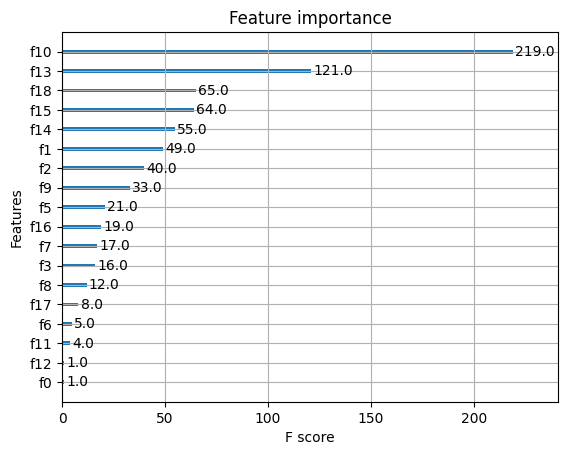

In [29]:
xgb.plot_importance(xgb_model)